<a href="https://colab.research.google.com/github/SahajTC/Augmented-Financial-Intelligence/blob/main/XGBoost_bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [129]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from prophet.diagnostics import cross_validation, performance_metrics
import seaborn as sns 
import matplotlib.pyplot as plt

In [158]:
bitcoindf = yf.download(tickers='BTC-USD', start='2018-01-01', end='2022-11-30', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [159]:
bitcoindf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [160]:
bitcoindf.reset_index(inplace=True)
bitcoindf['Date'] = pd.to_datetime(bitcoindf['Date'])
bitcoindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [161]:
closedf = bitcoindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1794, 2)


In [162]:
closedf = closedf[closedf['Date'] > '2019-04-20']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1319


In [163]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1319, 1)


In [178]:
training_size=int(len(closedf)*0.50)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (659, 1)
test_data:  (660, 1)


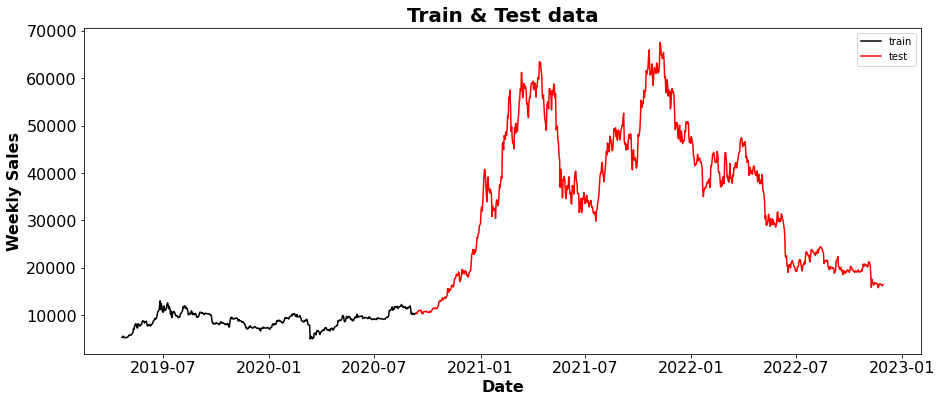

In [167]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:510], y = close_stock['Close'][:510], color = 'black')
sns.lineplot(x = close_stock['Date'][510:], y = close_stock['Close'][510:], color = 'red')

ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [124]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0,1,2,3.......
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [179]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (643, 15)
y_train:  (643,)
X_test:  (644, 15)
y_test (644,)


In [133]:
from xgboost import XGBRegressor
my_model = XGBRegressor( n_estimators=10000 )
my_model.fit(X_train, y_train, verbose=False)

[17:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10000)

In [180]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.041311195528198286
Root Mean squared Error - RMSE : 0.06037209515792998


In [176]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [181]:
mape(y_test,predictions)

13.723986219236009